# Galaxy Zoo Dataset Classification using Convolutional Neural Networks

## 1. Introduction

On this notebook, the Galaxy Zoo dataset is used with the aim of classifying each provided galaxy with its respective class. However, because of having too many classes to classify through with also an enourmous amount of images to train and test, the dataset was reduced in such a way that only some of the classes are relevant to the classification.


All in all, this notebook is divided in two parts:

1. First, the data is preprocessed in order to simplify the problem and reduce the amount of CPU power needed to solve it.

2. Secondly, using the prepared data, a Convolutonal Neural Network is made using several layers.

## 2. Library imports

**pandas**: In order to retrive the data from the csv files provided by the team responsible of Galaxy Zoo Challenge at Kaggle.

**tensorflow.keras**: On this notebook **Keras** is used, especifically, the version bundled with **TensorFlow**.

**matplotlib.pyplot**: For plotting.

**keras_preprocessing.***: It is used for image manipulation, for preprocessing or demonstration porpouses.

**os**, **random** and **shutil**: They are used at the moment of reading files from the system into python.

In [1]:
%matplotlib inline
import pandas as pd
import os, random, shutil

import tensorflow.keras as keras
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

/home/sobremesa/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sobremesa/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sobremesa/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sobremesa/.local/lib/python3.7/site-packages/tensorflow/python/framework/dty

## 3. Preprocessing

### 3.1 Reading the data

The variable defining where is the working directory storing all the files of the dataset.

In [2]:
base_path = r'.'

Importing into Python the training set's images from _images_training_rev1_ and their labels from the CSV file, both provided at Kaggle on the Galaxy Zoo Challenge (https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge).

In [3]:
training_solutions = os.path.join(base_path, 'training_solutions_rev1.csv')
training_images    = os.path.join(base_path, 'images_training_rev1')

Getting the values of the CSV file into a table.

In [4]:
df = pd.read_csv(training_solutions)

In [6]:
df.shape

(61578, 38)

In [7]:
df.head()

,GalaxyID,Q1.1,Q1.2,Q1.3,Q2.1,Q2.2,Q3.1,Q3.2,Q4.1,Q4.2,...,Q9.3,Q10.1,Q10.2,Q10.3,Q11.1,Q11.2,Q11.3,Q11.4,Q11.5,Q11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


### 3.2 Reducing the amount of classes

Originally there are 37 classes, but all of them are reduced to just 3 in the following way:

1. Elliptical galaxies (early type): Class1.1 > 0.8 and Class7.1 > 0.4
2. Lenticular galaxies (in-between): Class1.1 > 0.8 and Class7.2 > 0.4
3. Spiral galaxies (late type): Class1.2 > 0.8 and Class2.1 > 0.4

Where only the images that satisfy the conditions of the probability distributions are used for the classification. That makes the relevant dataset be much smaller than the original.

In [8]:
ellipticals = df[(df['Class1.1']>0.8) & (df['Class7.1']>0.4)]['GalaxyID'].tolist()

In [9]:
lenticulars = df[(df['Class1.1']>0.8) & (df['Class7.2']>0.4)]['GalaxyID'].tolist()

In [10]:
spirals = df[(df['Class1.2']>0.8) & (df['Class2.1']>0.4)]['GalaxyID'].tolist()

In [11]:
print('Total number of elliptical examples: ',  len(ellipticals))
print('Total number of lenticular examples: ',  len(lenticulars))
print('Total number of spiral examples: ',  len(spirals))

Total number of elliptical examples:  4555
Total number of lenticular examples:  3861
Total number of spiral examples:  3078


### 3.3 Making the new dataset

A function to copy the relevant images, in a random order, from the training set to a new folder where images will be stored in other subfolders corresponding to each of the 3 classes.

In [27]:
def _proc_images(src, dst, label, arr, percent):
    """
    src: Source images folder
    dst: Destination folder
    label: One of the 3 classes.
    arr: The probability distributions of the label obtained from the CSV file.
    percent: The percent of images of the label to be used for training. So 1 - percent would be used for testing.
    """
    train_dir = os.path.join(dst, 'train')
    val_dir = os.path.join(dst, 'validation')
    
    train_dest = os.path.join(train_dir, label)
    val_dest   = os.path.join(val_dir, label)
    
    if not os.path.exists(train_dest):
        os.makedirs(train_dest)

    if not os.path.exists(val_dest):
        os.makedirs(val_dest)
    
    random.shuffle(arr)
    
    idx = int(len(arr)*percent)
    for i in arr[0:idx]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(train_dest, str(i)+'.jpg'))
    for i in arr[idx:]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(val_dest, str(i)+'.jpg'))
    
    print(label, 'done!')

Images will be stored on the _data_ folder inside the working path ( _base\_path_ ).

In [13]:
my_data = os.path.join(base_path, 'data')

Previous function will be used for each relevant class (elliptical, lenticular and spiral) with %70 of the images used for training and the rest for testing.

In [14]:
_proc_images(training_images, my_data, 'elliptical', ellipticals, 0.7)
_proc_images(training_images, my_data, 'lenticular', lenticulars, 0.7)
_proc_images(training_images, my_data, 'spiral', spirals, 0.7)

elliptical done!
lenticular done!
spiral done!


In [15]:
print('Total train elliptical:', len(os.listdir(os.path.join(my_data, 'train', 'elliptical'))))
print('Total train lenticular:', len(os.listdir(os.path.join(my_data, 'train', 'lenticular'))))
print('Total train spiral:', len(os.listdir(os.path.join(my_data, 'train', 'spiral'))))

Total train elliptical: 4153
Total train lenticular: 3507
Total train spiral: 2798


In [16]:
print('Total validation elliptical:', len(os.listdir(os.path.join(my_data, 'validation', 'elliptical'))))
print('Total validation lenticular:', len(os.listdir(os.path.join(my_data, 'validation', 'lenticular'))))
print('Total validation spiral:', len(os.listdir(os.path.join(my_data, 'validation', 'spiral'))))

Total validation elliptical: 2332
Total validation lenticular: 1964
Total validation spiral: 1568


### 3.4 Galaxy image examples

#### Elliptical Class

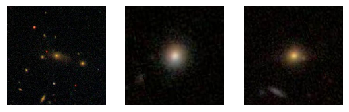

In [17]:
for num, file in enumerate(os.listdir(os.path.join(my_data, 'train', 'elliptical'))[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'elliptical', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)

#### Lenticular Class

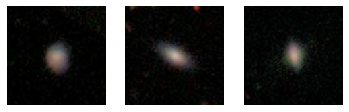

In [18]:
for num, file in enumerate(os.listdir(os.path.join(my_data, 'train', 'lenticular'))[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'lenticular', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)

#### Spiral Class

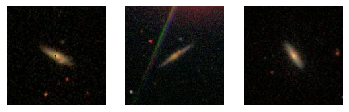

In [19]:
for num, file in enumerate(os.listdir(os.path.join(my_data, 'train', 'spiral'))[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'spiral', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)

In [20]:
print('The final dataset is available at:', my_data)

The final dataset is available at: ./data


## 4. Classification

In [21]:
train_dir = 'data/train'
validation_dir = 'data/validation'

In [22]:
BS = 32

In [24]:
total_train = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_train += len(os.listdir(os.path.join(train_dir, c)))
print('Total train:', total_train)

total_validation = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_validation += len(os.listdir(os.path.join(validation_dir, c)))
print('Total validation:', total_validation)

FileNotFoundError: [Errno 2] No such file or directory: 'data/train/elliptical'

In [25]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=25,
                                   width_shift_range=.15,
                                   height_shift_range=.15,
                                   horizontal_flip=True,
                                   zoom_range=0.2)
validation_datagen  = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size=BS,
                                                    shuffle=True,
                                                    class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                         target_size=(150,150),
                                                         batch_size=BS,
                                                         shuffle=False,
                                                         class_mode='categorical')

FileNotFoundError: [Errno 2] No such file or directory: 'data/train'

In [ ]:
model = keras.models.Sequential([
    # first convolution layer, input is an 150x150 image x3 colors
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    keras.layers.MaxPooling2D(2, 2),
    # second convolution layer
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # third convolution layer
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # fourth convolution layer
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # flatten the image pixels
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    # 512 neuron fully connected hidden layer
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
epochs = 100

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=total_train/BS,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=total_validation/BS,
                              verbose=1)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # range for the number of epochs

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./plots-v2.png')
plt.show()

In [ ]:
model.save('galaxy-convnet-v2.h5')